In [31]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path

In [32]:
# path = Path('/kaggle/input/animefacedataset/images')
#path = Path('/kaggle/input/anime-faces/data/data')
path = Path('/kaggle/input/atopy-all-data/atopy_data/')
len(os.listdir(path))

853

In [33]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [34]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)
print(dataset)

<TensorSliceDataset shapes: (), types: tf.string>


In [35]:
import cv2
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    #img = (img - 127.5) / 127.5
    img = img / 255
    img = tf.image.resize(img, (128, 128))
    return img

In [36]:
TOTAL=853
BATCH_SIZE=8

In [37]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [38]:
#dataset = dataset.shuffle(21551).batch(128, drop_remainder=True)
dataset = dataset.shuffle(TOTAL).batch(BATCH_SIZE, drop_remainder=True)

In [39]:
dataset = dataset.prefetch(32)

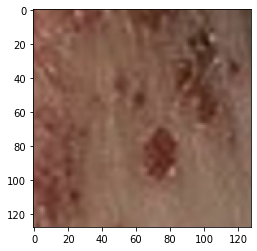

In [40]:
plt.imshow(next(dataset.as_numpy_iterator())[3])

In [41]:
next(dataset.as_numpy_iterator())[:8].shape

(8, 128, 128, 3)

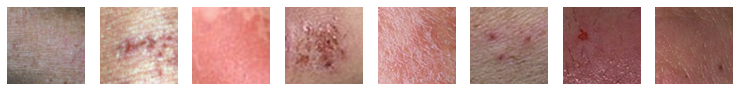

In [42]:
def show(images):
    fig, ax = plt.subplots(1, 8, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:8])

In [43]:
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

In [44]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [45]:
"""
def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)
"""
def critic(input_shape=(128, 128, 3), dim=128, n_downsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [46]:
d = critic()
d.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_layer_5 (ConvLayer)     (None, 64, 64, 128)       6400      
_________________________________________________________________
conv_layer_6 (ConvLayer)     (None, 32, 32, 256)       524800    
_________________________________________________________________
conv_layer_7 (ConvLayer)     (None, 16, 16, 512)       2098176   
_________________________________________________________________
conv_layer_8 (ConvLayer)     (None, 8, 8, 1024)        8390656   
_________________________________________________________________
conv_layer_9 (ConvLayer)     (None, 4, 4, 1024)        16779264  
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 1)           1638

In [47]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [48]:
# def generator(input_shape=(100), dim=64, n_upsampling=3):
#     input_ = Input(shape=input_shape)
#     X = Dense(4 * 4 * 32)(input_)
#     X = Reshape((4, 4, 32))(X)
#     X = deconv_layer(dim*8, 5, strides=1, padding='same')(X)
#     for i in range(n_upsampling):
#         X = deconv_layer(dim * 2 ** (n_upsampling-i-1), 5)(X)
        
#     X = Conv2DTranspose(3, 5, strides=2, padding='same')(X)
#     X = Activation('tanh')(X)
#     return keras.models.Model(inputs=input_, outputs=X)
def generator(input_shape=(1, 1, 128), output_channels=3, dim=128, n_upsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [49]:
g = generator()
g.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 1, 128)]       0         
_________________________________________________________________
upsample_block_5 (UpsampleBl (None, 4, 4, 1024)        2100224   
_________________________________________________________________
upsample_block_6 (UpsampleBl (None, 8, 8, 1024)        16780288  
_________________________________________________________________
upsample_block_7 (UpsampleBl (None, 16, 16, 512)       8390144   
_________________________________________________________________
upsample_block_8 (UpsampleBl (None, 32, 32, 256)       2097920   
_________________________________________________________________
upsample_block_9 (UpsampleBl (None, 64, 64, 128)       524672    
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 128, 128, 3)       6147

In [50]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [51]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [52]:
EPOCHS = 150

noise_dim = 128

In [53]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

In [54]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [55]:
seed = tf.random.normal((16, 1, 1, 128))

In [56]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

In [59]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=TOTAL//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

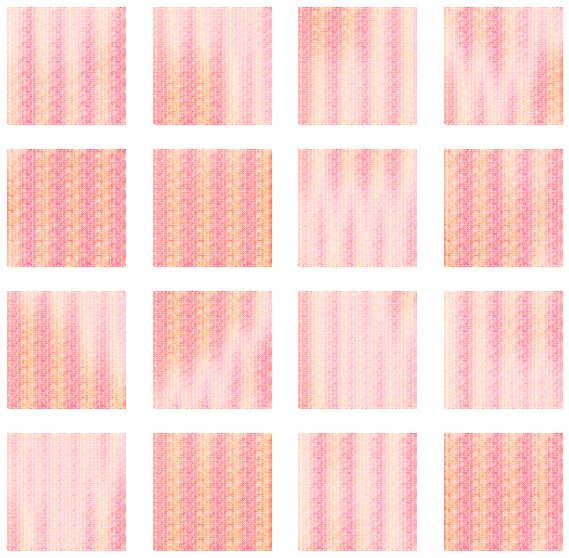

Time for epoch 150 is 33.68045663833618 sec


In [60]:
train(dataset, EPOCHS)

In [ ]:
optG.lr = 1e-4
optD.lr = 1e-4

In [ ]:
train(dataset, 10)

In [ ]:
train(dataset, 1000)

In [ ]:
traub(dataset, 2000)

In [ ]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128]))